In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx #Requires 'pip install networkx'
import community as community_louvain  # Requires 'pip install python-louvain'


In [259]:
df = pd.read_csv('/Users/brandonowens/Downloads/Fraud_Payments 2/data/fraud_payment_data', sep=',', header=0)
df

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498172,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498173,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498174,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498175,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [167]:
# Make sure all sender and beneficiary account values are strings. This is needed later. (NaN was a float...)
df['Sender_Account'] = df['Sender_Account'].astype(str)
df['Bene_Account'] = df['Bene_Account'].astype(str)

In [168]:
# The number of unique accounts occuring as a fraudulent sender (note: don't have to use .unique() here because we are calling set())

len(set(df['Sender_Account'].loc[df['Label']==1]))


11897

In [169]:
# The number of unique accounts occuring as a fraudulent beneficiary


len(set(df['Bene_Account'].loc[df['Label']==1]))

16517

In [170]:
# The number of unique accounts occuring as both a fraudulent sender and a fraudulent beneficiary
len(set(df['Sender_Account'].loc[df['Label']==1]).intersection(set(df['Bene_Account'].loc[df['Label']==1])))

6333

This suggests that more beneficiary accounts are involved in fraud. 

In [260]:
#Converting time into a Datetime object
df['timestamp'] = pd.to_datetime(df['Time_step'])
#Removing redudant columns
df=df.drop('Time_step',axis=1)
df=df.drop('Sender_lob',axis=1)
#df=df.drop('Sender_Sector',axis=1)
#Apparently some transactions amounted to zero dollars. None of them were fraudulent, so I've removed them.
df=df[df.USD_amount>0]
df

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,timestamp
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,WITHDRAWAL,2022-03-15 10:24:00
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,2022-03-15 10:24:00
2,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,2022-03-15 10:24:00
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,2022-03-15 10:24:00
4,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,2022-03-15 10:24:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1498172,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT,2054-09-14 13:17:24
1498173,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT,2054-09-15 00:57:24
1498174,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT,2054-09-15 01:17:24
1498175,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT,2054-09-15 12:57:24


In [316]:
#we will take about 70% of our dataset as training data, about 15% as a validation set and use the remaining 15% as our test set.
cutoff = round(0.7*len(df)) 
df_train = df.head(cutoff)
not_train =  df.tail(len(df)-cutoff)
cutoff2 = round(0.5*len(not_train))
df_val = df.head(cutoff2)
df_test = df.tail(len(not_train)-cutoff2)

In [296]:
# Make sure that the distribution of fraudulent/legitimate transactions are consistent across the three different sets.
print('The distribution of fraud for the train data is:\n', df_train['Label'].value_counts(normalize=True))
print('The distribution of fraud for the validation set is:\n', df_val['Label'].value_counts(normalize=True))
print('The distribution of fraud for the test set is:\n', df_test['Label'].value_counts(normalize=True))

The distribution of fraud for the train data is:
 Label
0    0.97893
1    0.02107
Name: proportion, dtype: float64
The distribution of fraud for the validation set is:
 Label
0    0.978934
1    0.021066
Name: proportion, dtype: float64
The distribution of fraud for the test set is:
 Label
0    0.980443
1    0.019557
Name: proportion, dtype: float64


Looks good.

In [321]:
# Check the intersection of the timestamps of the dataframes to make sure that the splits have no overlap.
set(df_train['timestamp']).intersection(set(df_val['timestamp'])).intersection(set(df_test['timestamp']))


set()

In [111]:
len(df_train)

1048708

In [174]:
G = nx.from_pandas_edgelist(
    df_train,
    source = 'Sender_Account',
    target = 'Bene_Account',
    edge_attr=['USD_amount', 'Label', 'timestamp'],
    create_using=nx.DiGraph())

partitions = community_louvain.best_partition(G.to_undirected())

print(f"Detected {len(set(partitions.values()))} communities.")

Detected 5665 communities.


In [48]:

len(set(df_train['Sender_Account'].loc[df_train['Label']==1]).union(set(df_train['Bene_Account'].loc[df_train['Label']==1])))

15636

In [51]:
len(set(df_train.loc[df_train['Label']==1]['Sender_Account']).union(set(df_train.loc[df_train['Label']==1]['Bene_Account'])))

15636

In [45]:
## Identify fraudulent nodes

fraudulent_nodes = set()
for a, b, data in G.edges(data = True):
        if data.get('Label')==1:
            fraudulent_nodes.add(a)
            fraudulent_nodes.add(b)


len(fraudulent_nodes)
#set(df['Sender_Account'].loc[df['Label']==1]).union(set(df['Bene_Account'].loc[df['Label']==1]))

8937

In [217]:
def network_grapher(dataframe):
    # create graph network from given dataframe
    G = nx.from_pandas_edgelist(
    dataframe,
    source = 'Sender_Account',
    target = 'Bene_Account',
    edge_attr=['USD_amount', 'Label', 'timestamp', 'Transaction_Id'],
    create_using=nx.MultiDiGraph())
    return G


def dataframe_feature_engineerer(graph, dataframe):
   
    # augments a data frame with some engineered features

    # First we generate dataframes to store all the info.
    # Then we merge all of the dataframes together into one.
    # Then we merge the original dataframe with our dataframe consisting of engineered features.




    ## ---- First we'll create a 'proximity_to_fraud' feature and integrate it into our original dataframe ------

    ## Identify fraudulent nodes
    fraudulent_nodes=set(dataframe.loc[dataframe['Label']==1]['Sender_Account']).union(set(dataframe.loc[dataframe['Label']==1]['Bene_Account']))


    # I asked Google to help write the following chunk of code... We can change it later.

    distance_to_fraud = {node: -1 for node in graph.nodes()}

    # For each node, find the shortest path length to *any* fraudulent node
    for source_node in graph.nodes():
        try:
            path_lengths = nx.shortest_path_length(graph, source=source_node)
            min_distance = float('inf')
            for target_node in fraudulent_nodes:
                if target_node in path_lengths:
                    min_distance = min(min_distance, path_lengths[target_node])
            if min_distance != float('inf'):
                distance_to_fraud[source_node] = min_distance
        except nx.NetworkXNoPath:
            # If a node is not connected to the main component, the distance is infinite
            pass

    # Assign distance as an edge attribute ---
    # For each edge (transaction), assign a feature representing its proximity to fraud.
    # The proximity is defined as the minimum distance of its two endpoints to a fraudulent node.

    # First, create a dictionary to store the new attributes
    proximity_scores = {}
    for u, v, key, data in graph.edges(data=True, keys=True):
        # Get the distances for the two nodes connected by the edge
        dist_u = distance_to_fraud.get(u, -1)
        dist_v = distance_to_fraud.get(v, -1)
    
        # Handle disconnected components by assigning a large value
        if dist_u == -1 or dist_v == -1:
            proximity = -1 # Or a very large number like float('inf')
        else:
            # The proximity of the edge is the minimum of the two endpoint distances
            proximity = min(dist_u, dist_v)

        # Store the result, using the transaction_id as the key
        proximity_scores[data['Transaction_Id']] = proximity


        # Now, update the original DataFrame with the new feature
    dataframe['proximity_to_fraud'] = dataframe['Transaction_Id'].map(proximity_scores)
    dataframe['proximity_to_fraud'].fillna(-1, inplace=True)

    # Update graph so that it has 'proximity to fraud as an edge attribute

    new_graph = nx.from_pandas_edgelist(
    dataframe,
    source = 'Sender_Account',
    target = 'Bene_Account',
    edge_attr=['USD_amount', 'Label', 'timestamp', 'Transaction_Id', 'proximity_to_fraud'],
    create_using=nx.MultiDiGraph())



    ## Louvain Community Partitioner 
    partitions = community_louvain.best_partition(new_graph.to_undirected(), weight='proximity_to_known_fraud')
    Louvain_community_df = pd.DataFrame.from_dict(partitions, orient='index', columns=['community_id'])
    Louvain_community_df.index.name = 'Account'
    #Louvain_community_df = Louvain_community_df.reset_index()
    #Louvain_community_df['Account'] = Louvain_community_df['Account'].astype(str)


    # Merge community information back into the transaction DataFrame
    dataframe = pd.merge(
        dataframe,
        Louvain_community_df, 
        left_on='Sender_Account',
        right_on='Account', 
        right_index=True, 
        how='left', 
        suffixes=('', '_sender')
    )
    dataframe = dataframe.merge(
        Louvain_community_df, 
        left_on='Bene_Account',
        right_on='Account', 
        right_index=True, 
        how='left', 
        suffixes=('_sender', '_beneficiary')
    )

    # Create community-based features
    dataframe['same_community'] = (dataframe['community_id_sender'] == dataframe['community_id_beneficiary']).astype(int)

    # Calculate and map the average fraud rate within each community
    community_fraud_rate = dataframe.groupby('community_id_sender')['Label'].mean().to_dict()
    dataframe['community_fraud_rate_sender'] = dataframe['community_id_sender'].map(community_fraud_rate)
    dataframe['community_fraud_rate_beneficiary'] = dataframe['community_id_beneficiary'].map(community_fraud_rate)

    ''''# Calculate and map the size of each community
    community_size = Louvain_community_df.groupby('community_id')['Account'].count().to_dict()
    dataframe['community_size_sender'] = dataframe['community_id_sender'].map(community_size)
    dataframe['community_size_beneficiary'] = dataframe['community_id_beneficiary'].map(community_size)'''



    ## Feature Engineering 


    # determines which accounts are known to have been involved in a fraudulent transaction
    known_fraud_accounts = set(dataframe[dataframe['Label'] == 1]['Sender_Account']).union(set(dataframe[dataframe['Label'] == 1]['Bene_Account']))
    df_known_fraud = pd.DataFrame(known_fraud_accounts, columns=['Account'])
    df_known_fraud['is_known_fraud'] = 1

    # stores number of transactions going into each account
    df_in_degree = pd.DataFrame(new_graph.in_degree(), columns = ['Account', 'in_degree'])

    # stores number of tranactions going out of each account
    df_out_degree = pd.DataFrame(new_graph.out_degree(), columns = ['Account', 'out_degree'])

    # "computes a ranking of the nodes in the graph G based on the structure of the incoming links" (from networkx documentation)
    # accounts with high pagerank are highly connected. Could expose fraud rings?
    df_pagerank = pd.DataFrame(nx.pagerank(new_graph, weight='USD_amount').items(), columns=['Account', 'pagerank'])
    
    
    ## Merging the dataframes for engineered features
    account_features = (
    df_in_degree.merge(df_out_degree, on='Account', how='outer')
    .merge(df_pagerank, on='Account', how='outer')
    #.merge(df_clustering, on='Account', how='outer')
    .merge(df_known_fraud, on='Account', how='left')
    .fillna(0) # Fill NaN values, assuming 0 for accounts without a specific feature
    )
     #.merge(df_katz_centrality, on='account', how = 'outer')

    # Rename columns for clarity before merging into original dataframe
    account_features_sender = account_features.add_prefix('Sender_')
    account_features_benefactor = account_features.add_prefix('Bene_')

    


    ## Merging features back into the main transaction DataFrame
    dataframe = dataframe.merge(account_features_sender, on='Sender_Account', how='left')
    new_dataframe = dataframe.merge(account_features_benefactor, on='Bene_Account', how='left')

    new_dataframe['First_Number'] = new_dataframe['USD_amount'].astype(str).str[0]


    return new_dataframe



In [223]:
new_graph = network_grapher(df_train)

In [224]:
aug_df = dataframe_feature_engineerer(new_graph, df_train)

/var/folders/gx/0s3fljln63s_05xzs9lx30p40000gn/T/ipykernel_20685/2353105434.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['proximity_to_fraud'] = dataframe['Transaction_Id'].map(proximity_scores)
/var/folders/gx/0s3fljln63s_05xzs9lx30p40000gn/T/ipykernel_20685/2353105434.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perf

In [322]:
# proximity to fraud never seems to get above 3 here...
aug_df['proximity_to_fraud'].value_counts(normalize = True)


proximity_to_fraud
 0    0.496711
-1    0.298000
 1    0.205001
 2    0.000268
 3    0.000020
Name: proportion, dtype: float64

In [226]:
aug_df

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,...,community_fraud_rate_beneficiary,Sender_in_degree,Sender_out_degree,Sender_pagerank,Sender_is_known_fraud,Bene_in_degree,Bene_out_degree,Bene_pagerank,Bene_is_known_fraud,First_Number
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,NaN,nan,NaN,558.43,0,WITHDRAWAL,...,0.021508,8,31,0.000006,0.0,150949,153299,0.046568,1.0,5
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,...,0.000000,11,27,0.000014,0.0,35,7,0.000014,0.0,6
2,DEPOSIT-CASH-9833,NaN,nan,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,...,0.084270,150949,153299,0.046568,1.0,16,41,0.000015,1.0,8
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,...,0.084270,20,39,0.000012,1.0,26,12,0.000010,1.0,9
4,DEPOSIT-CHECK-9806,NaN,nan,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,...,0.021508,150949,153299,0.046568,1.0,1,0,0.000003,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048703,QUICK-PAYMENT-1536550,COMPANY-1536520,ACCOUNT-1536525,FRENCH-GUIANA,JPMC-CLIENT-1536517,ACCOUNT-1536527,USA,497.19,0,QUICK-PAYMENT,...,0.021508,1,1,0.000005,0.0,3,4,0.000007,0.0,4
1048704,DEPOSIT-CHECK-1531307,NaN,nan,NaN,JPMC-CLIENT-1531271,ACCOUNT-1531281,USA,176.37,0,DEPOSIT-CHECK,...,0.021508,150949,153299,0.046568,1.0,4,6,0.000010,1.0,1
1048705,PAY-CHECK-1530565,JPMC-CLIENT-1530535,ACCOUNT-1530546,USA,JPMC-CLIENT-1530536,ACCOUNT-1530549,CANADA,120.51,0,PAY-CHECK,...,0.000000,3,5,0.000011,0.0,1,3,0.000004,0.0,1
1048706,PAY-CHECK-1540064,JPMC-CLIENT-1540029,ACCOUNT-1540040,USA,CLIENT-1540049,ACCOUNT-1540050,USA,223.58,0,PAY-CHECK,...,0.000000,4,6,0.000011,0.0,9,3,0.000009,0.0,2


In [227]:
aug_df.to_csv('augmented_transaction_dataframe_train.csv', index=False)

In [323]:
# I guess I accidentally forgot to change the numbers from strings into integers earlier
aug_df['First_Number'] = aug_df['First_Number'].astype(int)

In [261]:
# and I forgot to include sender sector...oops
aug_df['Sender_Sector'] = df['Sender_Sector']

In [262]:
# Let's update that csv file so that it includes sendor sector.
aug_df.to_csv('augmented_transaction_dataframe_train.csv', index=False)

In [264]:
# Give NaN a new numerical value in Sender Sector
aug_df['Sender_Sector'] = aug_df['Sender_Sector'].fillna(-1)

# Compute fraud rate by sector and add values in a new column
fraud_rate_by_sector = aug_df.groupby('Sender_Sector')['Label'].mean()

aug_df['fraud_rate_by_sector'] = aug_df['Sender_Sector'].map(fraud_rate_by_sector)
aug_df 

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,...,Sender_out_degree,Sender_pagerank,Sender_is_known_fraud,Bene_in_degree,Bene_out_degree,Bene_pagerank,Bene_is_known_fraud,First_Number,Sender_Sector,fraud_rate_by_sector
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,NaN,nan,NaN,558.43,0,WITHDRAWAL,...,31,0.000006,0.0,150949,153299,0.046568,1.0,5,35537.0,0.000000
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,...,27,0.000014,0.0,35,7,0.000014,0.0,6,15287.0,0.047619
2,DEPOSIT-CASH-9833,NaN,nan,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,...,153299,0.046568,1.0,16,41,0.000015,1.0,8,-1.0,0.022418
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,...,39,0.000012,1.0,26,12,0.000010,1.0,9,38145.0,0.000000
4,DEPOSIT-CHECK-9806,NaN,nan,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,...,153299,0.046568,1.0,1,0,0.000003,0.0,7,-1.0,0.022418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048703,QUICK-PAYMENT-1536550,COMPANY-1536520,ACCOUNT-1536525,FRENCH-GUIANA,JPMC-CLIENT-1536517,ACCOUNT-1536527,USA,497.19,0,QUICK-PAYMENT,...,1,0.000005,0.0,3,4,0.000007,0.0,4,9053.0,0.037037
1048704,DEPOSIT-CHECK-1531307,NaN,nan,NaN,JPMC-CLIENT-1531271,ACCOUNT-1531281,USA,176.37,0,DEPOSIT-CHECK,...,153299,0.046568,1.0,4,6,0.000010,1.0,1,44841.0,0.000000
1048705,PAY-CHECK-1530565,JPMC-CLIENT-1530535,ACCOUNT-1530546,USA,JPMC-CLIENT-1530536,ACCOUNT-1530549,CANADA,120.51,0,PAY-CHECK,...,5,0.000011,0.0,1,3,0.000004,0.0,1,-1.0,0.022418
1048706,PAY-CHECK-1540064,JPMC-CLIENT-1540029,ACCOUNT-1540040,USA,CLIENT-1540049,ACCOUNT-1540050,USA,223.58,0,PAY-CHECK,...,6,0.000011,0.0,9,3,0.000009,0.0,2,-1.0,0.022418


In [269]:
# Let's update that csv file so that it includes fraud by sender sector.
aug_df.to_csv('augmented_transaction_dataframe_train.csv', index=False)

## Training Models

In [241]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



In [355]:
train_fraud_count = aug_df['Label'].sum()
train_normal_count = len(aug_df['Label']) - train_fraud_count
fraud_train_scale_pos_weight = train_normal_count / train_fraud_count

xgb_search = GridSearchCV(XGBClassifier(random_state = 831, scale_pos_weight = fraud_train_scale_pos_weight ),
                       param_grid= {'learning_rate':[0.01, 0.1, 1,],
                       'n_estimators': [100, 300, 500, 700],
                       'max_depth': [10,30,50,70,90,100]},
                                    scoring = 'f1',
                                    cv = 5)

In [313]:
features = ['USD_amount', 'proximity_to_fraud',
       'community_fraud_rate_sender', 'community_fraud_rate_beneficiary',
       'Sender_in_degree', 'Sender_out_degree', 'Sender_pagerank',
       'Sender_is_known_fraud', 'Bene_in_degree', 'Bene_out_degree',
       'Bene_pagerank', 'Bene_is_known_fraud', 'First_Number']

In [251]:
xgb_search.fit(aug_df[features], aug_df['Label'])

,estimator,"XGBClassifier...tate=831, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [10, 30, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [324]:
print(xgb_search.best_params_)

{'learning_rate': 0.01, 'max_depth': 90, 'n_estimators': 300}


In [255]:
print(xgb_search.best_score_)

0.3010892066811144


In [268]:
xgb_search.best_estimator_

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [273]:
best_params = xgb_search.best_params_

In [271]:
more_features = ['USD_amount', 'proximity_to_fraud',
       'community_fraud_rate_sender', 'community_fraud_rate_beneficiary',
       'Sender_in_degree', 'Sender_out_degree', 'Sender_pagerank',
       'Sender_is_known_fraud', 'Bene_in_degree', 'Bene_out_degree',
       'Bene_pagerank', 'Bene_is_known_fraud', 'First_Number', 'fraud_rate_by_sector']

In [336]:
more_more_features = ['USD_amount', 'proximity_to_fraud',
       'community_fraud_rate_sender', 'community_fraud_rate_beneficiary',
       'Sender_in_degree', 'Sender_out_degree', 'Sender_pagerank',
       'Sender_is_known_fraud', 'Bene_in_degree', 'Bene_out_degree',
       'Bene_pagerank', 'Bene_is_known_fraud', 'First_Number', 'fraud_rate_by_sector', 'Label']

In [ ]:
sns.heatmap()

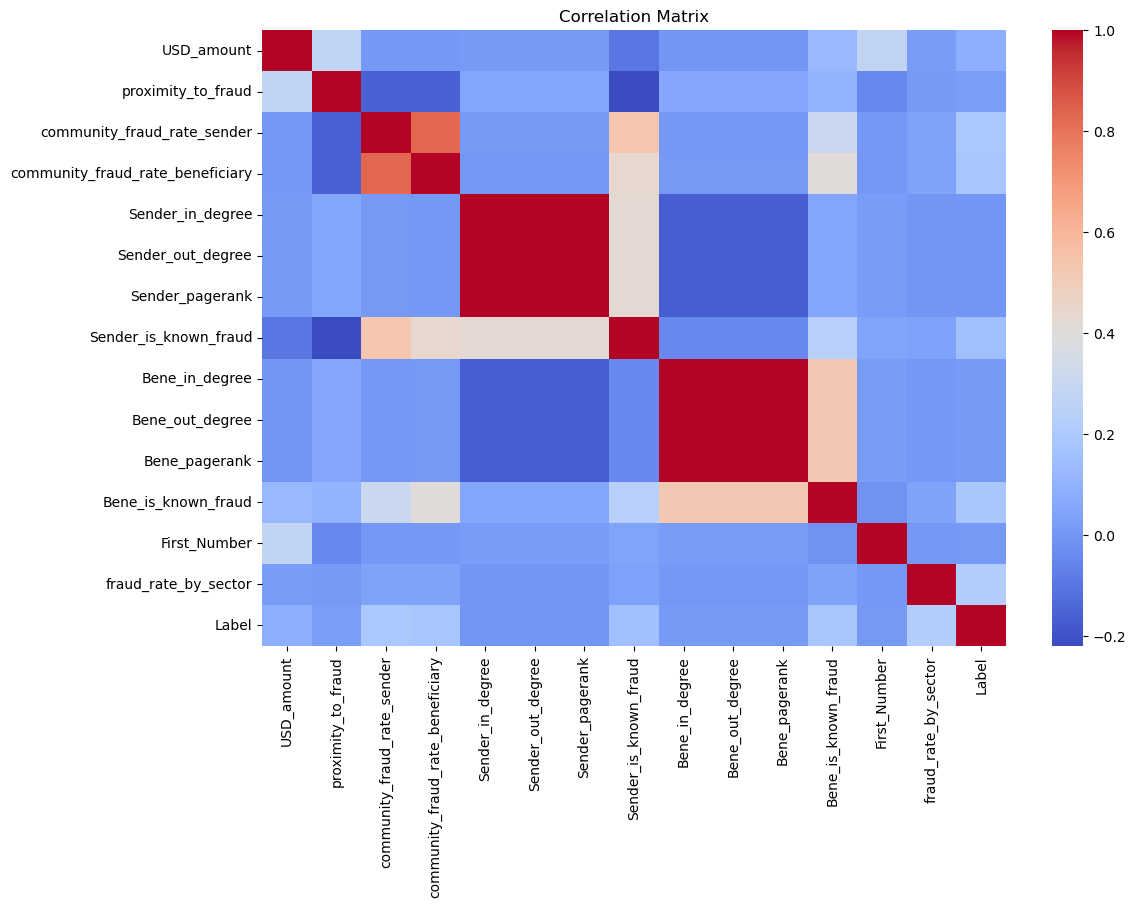

In [338]:
##Looking at the correlation matrix for our features in our training data
corr_matrix = aug_df[more_more_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [349]:
best_params

{'learning_rate': 0.01, 'max_depth': 90, 'n_estimators': 300}

In [365]:
optimized_xgb_model = XGBClassifier(**best_params, scale_pos_weight = fraud_train_scale_pos_weight )

In [366]:
optimized_xgb_model.fit(aug_df[more_features], aug_df['Label'])


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [297]:
new_graph_val = network_grapher(df_val)
aug_val_df = dataframe_feature_engineerer(new_graph_val, df_val)

/var/folders/gx/0s3fljln63s_05xzs9lx30p40000gn/T/ipykernel_20685/2353105434.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['proximity_to_fraud'] = dataframe['Transaction_Id'].map(proximity_scores)
/var/folders/gx/0s3fljln63s_05xzs9lx30p40000gn/T/ipykernel_20685/2353105434.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perf

In [298]:
aug_val_df['Sender_Sector'] = df_val['Sender_Sector']

# Give NaN a new numerical value in Sender Sector
aug_val_df['Sender_Sector'] = aug_val_df['Sender_Sector'].fillna(-1)

# Compute fraud rate by sector and add values in a new column
fraud_rate_by_sector = aug_val_df.groupby('Sender_Sector')['Label'].mean()

aug_val_df['fraud_rate_by_sector'] = aug_val_df['Sender_Sector'].map(fraud_rate_by_sector)





In [299]:
aug_val_df

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,...,Sender_in_degree,Sender_out_degree,Sender_pagerank,Sender_is_known_fraud,Bene_in_degree,Bene_out_degree,Bene_pagerank,Bene_is_known_fraud,First_Number,fraud_rate_by_sector
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,...,8.0,31.0,0.000030,0.0,NaN,NaN,NaN,NaN,5,0.000000
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,...,11.0,27.0,0.000086,0.0,35.0,7.0,0.000083,0.0,6,0.000000
2,DEPOSIT-CASH-9833,NaN,NaN,NaN,-1.0,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,...,NaN,NaN,NaN,NaN,16.0,41.0,0.000077,1.0,8,0.022993
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,...,20.0,39.0,0.000066,1.0,26.0,12.0,0.000047,1.0,9,0.000000
4,DEPOSIT-CHECK-9806,NaN,NaN,NaN,-1.0,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,...,NaN,NaN,NaN,NaN,1.0,0.0,0.000015,0.0,7,0.022993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224719,CASH-CHECK-332095,JPMC-CLIENT-332069,ACCOUNT-332083,USA,22869.0,NaN,NaN,NaN,553.01,0,...,0.0,4.0,0.000013,0.0,NaN,NaN,NaN,NaN,5,0.000000
224720,CASH-CHECK-330590,NaN,NaN,NaN,-1.0,JPMC-CLIENT-330566,ACCOUNT-330576,USA,100.15,0,...,NaN,NaN,NaN,NaN,1.0,4.0,0.000013,0.0,1,0.022993
224721,QUICK-PAYMENT-329987,CLIENT-329983,ACCOUNT-329984,USA,42450.0,JPMC-CLIENT-329965,ACCOUNT-329975,USA,746.55,0,...,3.0,1.0,0.000048,0.0,1.0,4.0,0.000053,0.0,7,0.000000
224722,QUICK-DEPOSIT-328880,NaN,NaN,NaN,-1.0,JPMC-CLIENT-328856,ACCOUNT-328866,USA,207.07,0,...,NaN,NaN,NaN,NaN,2.0,3.0,0.000016,0.0,2,0.022993


In [311]:
aug_val_df['First_Number'] = aug_val_df['First_Number'].astype(int)

In [367]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

y_true = aug_val_df['Label']
y_pred = optimized_xgb_model.predict(aug_val_df[more_features])


val_f1_score = f1_score(y_true, y_pred)
val_acc_score = accuracy_score(y_true, y_pred)
val_recall_score = recall_score(y_true, y_pred)
val_precision_score = precision_score(y_true, y_pred)

print(val_f1_score)
print(val_recall_score)
print(val_precision_score)

#val_f1_score = f1_score(aug_val_df['Label'], optimized_xgb_model.predict[features])

0.7045616899683641
0.7291930713983946
0.6815399802566634


In [330]:
aug_df

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,...,Sender_out_degree,Sender_pagerank,Sender_is_known_fraud,Bene_in_degree,Bene_out_degree,Bene_pagerank,Bene_is_known_fraud,First_Number,Sender_Sector,fraud_rate_by_sector
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,NaN,nan,NaN,558.43,0,WITHDRAWAL,...,31,0.000006,0.0,150949,153299,0.046568,1.0,5,35537.0,0.000000
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,...,27,0.000014,0.0,35,7,0.000014,0.0,6,15287.0,0.047619
2,DEPOSIT-CASH-9833,NaN,nan,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,...,153299,0.046568,1.0,16,41,0.000015,1.0,8,-1.0,0.022418
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,...,39,0.000012,1.0,26,12,0.000010,1.0,9,38145.0,0.000000
4,DEPOSIT-CHECK-9806,NaN,nan,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,...,153299,0.046568,1.0,1,0,0.000003,0.0,7,-1.0,0.022418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048703,QUICK-PAYMENT-1536550,COMPANY-1536520,ACCOUNT-1536525,FRENCH-GUIANA,JPMC-CLIENT-1536517,ACCOUNT-1536527,USA,497.19,0,QUICK-PAYMENT,...,1,0.000005,0.0,3,4,0.000007,0.0,4,9053.0,0.037037
1048704,DEPOSIT-CHECK-1531307,NaN,nan,NaN,JPMC-CLIENT-1531271,ACCOUNT-1531281,USA,176.37,0,DEPOSIT-CHECK,...,153299,0.046568,1.0,4,6,0.000010,1.0,1,44841.0,0.000000
1048705,PAY-CHECK-1530565,JPMC-CLIENT-1530535,ACCOUNT-1530546,USA,JPMC-CLIENT-1530536,ACCOUNT-1530549,CANADA,120.51,0,PAY-CHECK,...,5,0.000011,0.0,1,3,0.000004,0.0,1,-1.0,0.022418
1048706,PAY-CHECK-1540064,JPMC-CLIENT-1540029,ACCOUNT-1540040,USA,CLIENT-1540049,ACCOUNT-1540050,USA,223.58,0,PAY-CHECK,...,6,0.000011,0.0,9,3,0.000009,0.0,2,-1.0,0.022418


In [ ]:
pd.DataFrame({'feature importance score':xgb_search.best_estimator_.feature_importances_}, index=features).sort_values(by= 'feature importance score', ascending=False)


In [329]:
# Out of curiosity, let's fit our optimized xgboost model on our training data and use cross validation to get an average f1_score.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=False)

cross_val_results = cross_validate(optimized_xgb_model, aug_df[more_features], aug_df['Label'], cv = strat_kfold, scoring = ['f1', 'recall', 'precision'], return_train_score=True )

print(cross_val_results)
mean()

{'fit_time': array([8.61107993, 9.08972287, 9.20205402, 9.13477421, 9.11230683]), 'score_time': array([0.33376694, 0.35806489, 0.32484698, 0.31155086, 0.31270933]), 'test_f1': array([0.39102054, 0.39490862, 0.39400631, 0.40320256, 0.41728625]), 'train_f1': array([0.94546319, 0.94328269, 0.94572584, 0.94429898, 0.94572168]), 'test_recall': array([0.27789093, 0.27381761, 0.28257919, 0.28490609, 0.3048201 ]), 'train_recall': array([0.89981332, 0.89568366, 0.90003394, 0.89766363, 0.89941732]), 'test_precision': array([0.65950591, 0.70801638, 0.65052083, 0.68948521, 0.66126657]), 'train_precision': array([0.99599249, 0.99622475, 0.99630511, 0.99604545, 0.99705255])}


In [339]:
np.mean([0.39102054, 0.39490862, 0.39400631, 0.40320256, 0.41728625])

np.float64(0.400084856)

Interesting. The mean f1 on the cross-validation test sets is 0.40. I think there might be an issue with the method of forming the splits.

In [331]:
# Out of curiosity, let's fit our optimized xgboost model on our training data and use cross validation to get an average f1_score, but without fraud rate by sector

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=False)

cross_val_results = cross_validate(optimized_xgb_model, aug_df[features], aug_df['Label'], cv = strat_kfold, scoring = ['f1', 'recall', 'precision'], return_train_score=True )

print(cross_val_results)

{'fit_time': array([8.78091407, 9.22100377, 9.48596311, 9.20865512, 8.98858905]), 'score_time': array([0.38254404, 0.36924124, 0.49870086, 0.30093288, 0.29711699]), 'test_f1': array([0.39102054, 0.39490862, 0.39400631, 0.40320256, 0.41728625]), 'train_f1': array([0.94546319, 0.94328269, 0.94572584, 0.94429898, 0.94572168]), 'test_recall': array([0.27789093, 0.27381761, 0.28257919, 0.28490609, 0.3048201 ]), 'train_recall': array([0.89981332, 0.89568366, 0.90003394, 0.89766363, 0.89941732]), 'test_precision': array([0.65950591, 0.70801638, 0.65052083, 0.68948521, 0.66126657]), 'train_precision': array([0.99599249, 0.99622475, 0.99630511, 0.99604545, 0.99705255])}


Mean looks to be the same after getting rid of `fraud_rate_by_sector` feature.

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Dataframes To Use and an optimized XGBoostClassifer

In [368]:
# Here is the augmented training set dataframe. I have been calling it aug_df up until now, but I am renaming here it as aug_train_df for clarity.
aug_train_df = aug_df

# and here is the feature list which was used to train our best (as of now) performing model
more_features


['USD_amount',
 'proximity_to_fraud',
 'community_fraud_rate_sender',
 'community_fraud_rate_beneficiary',
 'Sender_in_degree',
 'Sender_out_degree',
 'Sender_pagerank',
 'Sender_is_known_fraud',
 'Bene_in_degree',
 'Bene_out_degree',
 'Bene_pagerank',
 'Bene_is_known_fraud',
 'First_Number',
 'fraud_rate_by_sector']

In [348]:
# Here is the augmented validation set dataframe. 
aug_val_df

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,...,Sender_in_degree,Sender_out_degree,Sender_pagerank,Sender_is_known_fraud,Bene_in_degree,Bene_out_degree,Bene_pagerank,Bene_is_known_fraud,First_Number,fraud_rate_by_sector
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,...,8.0,31.0,0.000030,0.0,NaN,NaN,NaN,NaN,5,0.000000
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,...,11.0,27.0,0.000086,0.0,35.0,7.0,0.000083,0.0,6,0.000000
2,DEPOSIT-CASH-9833,NaN,NaN,NaN,-1.0,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,...,NaN,NaN,NaN,NaN,16.0,41.0,0.000077,1.0,8,0.022993
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,...,20.0,39.0,0.000066,1.0,26.0,12.0,0.000047,1.0,9,0.000000
4,DEPOSIT-CHECK-9806,NaN,NaN,NaN,-1.0,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,...,NaN,NaN,NaN,NaN,1.0,0.0,0.000015,0.0,7,0.022993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224719,CASH-CHECK-332095,JPMC-CLIENT-332069,ACCOUNT-332083,USA,22869.0,NaN,NaN,NaN,553.01,0,...,0.0,4.0,0.000013,0.0,NaN,NaN,NaN,NaN,5,0.000000
224720,CASH-CHECK-330590,NaN,NaN,NaN,-1.0,JPMC-CLIENT-330566,ACCOUNT-330576,USA,100.15,0,...,NaN,NaN,NaN,NaN,1.0,4.0,0.000013,0.0,1,0.022993
224721,QUICK-PAYMENT-329987,CLIENT-329983,ACCOUNT-329984,USA,42450.0,JPMC-CLIENT-329965,ACCOUNT-329975,USA,746.55,0,...,3.0,1.0,0.000048,0.0,1.0,4.0,0.000053,0.0,7,0.000000
224722,QUICK-DEPOSIT-328880,NaN,NaN,NaN,-1.0,JPMC-CLIENT-328856,ACCOUNT-328866,USA,207.07,0,...,NaN,NaN,NaN,NaN,2.0,3.0,0.000016,0.0,2,0.022993


In [375]:
# Here are the parameters we found after tuning. This combination gives us our best performing XGBoost Classifier.
# Note that the scale_pos_weight parameter is determined based on the training data alone. This is important to avoid an instances of data leakage. 
# As a reminder, this variable fraud_train_scale_pos_weight was defined as follows:
# ((number of transactions in training data) - (number of fraudulent transactions in training data))/(number of fraudulent transactions in training data)


best_xgbclassifier_parameters = {'learning_rate': 0.01, 'max_depth': 90, 'n_estimators': 300, 'scale_pos_weight': fraud_train_scale_pos_weight}

In [373]:
# Here I'm instantiating the XGBoostClassifier model with our best parameters.

optimized_xgb_classifier_model = XGBClassifier(**best_xgbclassifier_parameters)

In [ ]:
# And here I'm performing a sanity check to make sure that everything I have renamed above is still working as intended.

optimized_xgb_classifier_model.fit(aug_train_df[more_features], aug_train_df['Label'])


y_true = aug_val_df['Label']
y_pred = optimized_xgb_classifier_model.predict(aug_val_df[more_features])


val_f1_score = f1_score(y_true, y_pred)
print(val_f1_score)

0.7045616899683641


In [376]:
# Exporting the dataframe to a csv file
aug_train_df.to_csv('augmented_training_transaction_dataframe.csv', index=False)

In [377]:
# Exporting the dataframe to a csv file
aug_val_df.to_csv('augmented_validation_transaction_dataframe.csv', index=False)